# Automated Data Processing and Clustering Pipeline

In [1]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from helper_functions import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

# Modify if the raw data structure changed
trash_columns = ['id_x_x','sikka_sub_task_operation_x_x','office_x_x','guarantor_x','patient','description','visible_to_patient','primary_insurance_estimate','secondary_insurance_estimate','plan_sr_no','insurance_payment','approved','from_pms_x_x','id_y_x','from_pms_y_x','sikka_sub_task_y_x','sikka_sub_task_operation_y_x','uuid','guarantor_y','office_y_x','fullname','first_name','last_name','address','phone','zip_code','practice','primary_insurance_company_id','profile_picture','date_joined','zip_code_flag','address_comp','final_zip_code','id_x_y','from_pms_x_y','office_x_y','treatment','id_y_y','from_pms_y_y','sikka_sub_task_y_y','sikka_sub_task_operation_y_y','office_y_y','procedure_code_x','procedure_code_description','patient_friendly_description','treatment_id','price','fetched_zip_code_flag','zip_code_verified','fetched_zip_code', 'entry_date', 'tooth_from']
meta_cols = ['provider_x', 'amount', 'treatment_plan_status', 'patient_id', 'city','state_y', 'sikka_provider_id', 'LATITUDE', 'LONGITUDE', 'procedure_age', 'visit_period']
base_cols = ['patient_id', 'procedure_age']

Fill in resource paths

In [7]:
# To be filled (Need to update)
# Path to helper_function.py
helper_function_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Recommondation_Trajectory\helper_functions.py"
# Path to raw full data
full_dataset_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
# Path to store age splitted data (suppose to be an empty file)
Splitted_age_group_output = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test"
# Path to the procedure code mapping excel file
Procedure_code_description_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M24\Procedure_Description_Mapping.xlsx"
# Define age group boundary (Need to update)
Interested_age = 33 # e.g., if input is 31, then we are interested in 30-35; if input is 66, then we are interested in 65-70
# Fill in interested procedure code
target_code='99111'

## Preprocessing, KMeans and Analysis and Insights

In [3]:
# Data Loading (No need to rerun if variables are changed)
lower_boundary = Interested_age // 5 * 5
upper_boundary = lower_boundary + 5
age_group_dir = os.path.join(Splitted_age_group_output, f"age_group_v1v3_{lower_boundary}-{upper_boundary}.csv")

full_dataset = full_dataset_path
df = pd.read_csv(full_dataset, encoding="Windows-1252")

# Delete trash columns and clean the data
df = drop_high_nan_columns(df) # Drop columns with more than 50% missing values
df = df.drop(columns = trash_columns) # Drop trash cols
df = merge_columns_with_priority(df,'health_category','procedure_code_category','treatment_category') # merge to get treatment_category with pattern from two category groups
df = df.dropna() # Drop the remaining NA
df, df_dict = object_processing(df) # Project columns dtype = object; For columns containing datetime, convert it to pd.datetime; For other object columns, encode them
df = days_cal_v2(df,'procedure_date','birth_date', 'procedure_age') # procedure_age
df = days_cal_v2(df,'last_visit','first_visit','visit_period') # visit_period
df = one_hot_encode_procedure_and_treatment(df) # # Perform one-hot encoding on the "procedure_code_y" and "treatment_category"

## Store the data loaclly and make a copy for next steps' use
# df.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\output.csv', index=False)
df_next = df.copy()

# Data Segmentation
patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()
patient_versions.columns = ['patient_id', 'version']
df_next = df_next.merge(patient_versions, on='patient_id')

# Define each dataset version
df_v1 = df_next[df_next['version'] == 'V1']
df_v2 = df_next[df_next['version'] == 'V2']
df_v3 = df_next[df_next['version'] == 'V3']
df_v4 = df_next[df_next['version'] == 'V4']
df_v1_v3 = df_next[df_next['version'].isin(['V1', 'V3'])]

# Split and save each group
df_v1_v3['age_group'] = df_v1_v3['procedure_age'].apply(age_to_group_5_year)
os.makedirs(Splitted_age_group_output, exist_ok=True)
for group_name, group_df in df_v1_v3.groupby('age_group'):
    filename = os.path.join(Splitted_age_group_output, f"age_group_v1v3_{group_name}.csv")
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_0-5.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_10-15.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_15-20.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_20-25.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_25-30.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_30-35.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_35-40.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_40-45.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_45-5

In [4]:
# Aggregating, Combining historical data and Clustering

# Select relevant columns and store as df_subset
procedure_cols = [col for col in df_next.columns if col.startswith('procedure_code_y_') or col.startswith('treatment_category_')]
df_subset = df_next[base_cols + procedure_cols].copy()
df_subset['procedure_age'] = df_subset['procedure_age'].astype(int) # procedure_age to int

# Melt one-hot to long format
df_long = df_subset.melt(id_vars=['patient_id', 'procedure_age'], value_vars=procedure_cols, var_name='procedure_code', value_name='occurred')
df_long = df_long[df_long['occurred'] == 1]
df_long['feature'] = df_long['procedure_code'] + '_age' + df_long['procedure_age'].astype(str)
# by version of June 1st, there are 665,030 true occured results in df_long

# Patients in the interested age group:
df_test = df_long.loc[(df_long['procedure_age'] >= lower_boundary) & (df_long['procedure_age'] < upper_boundary)]
unique_patient = df_test['patient_id'].unique()

# Store the historical and future dataset for these patient
filtered_df_hist = df_long[(df_long['patient_id'].isin(unique_patient)) & (df_long['procedure_age'] < lower_boundary)]
filtered_df_fut = df_long[(df_long['patient_id'].isin(unique_patient)) & (df_long['procedure_age'] >= upper_boundary)]

# Pivot to wide format
df_hist = filtered_df_hist.groupby(['patient_id', 'feature']).size().unstack(fill_value=0).reset_index()
df_fut = filtered_df_fut.groupby(['patient_id', 'feature']).size().unstack(fill_value=0).reset_index()

# Get metadata for wide format
patient_meta = df_next[meta_cols].groupby('patient_id').first().reset_index()
df_hist = pd.merge(patient_meta, df_hist, on='patient_id', how='left').fillna(0)
df_fut = pd.merge(patient_meta, df_fut, on='patient_id', how='left').fillna(0)

# Extract binary columns
df_target_age = pd.read_csv(age_group_dir)
binary_cols = [col for col in df_target_age .columns if (col.startswith('procedure_code_y_') or col.startswith('treatment_category_'))]

# Group by patient and aggregate with sum
agg_binary = df_target_age.groupby("patient_id")[binary_cols].sum()

# Combine each patient's complete treatment history in the past with their current age group treatments
df_combined = pd.merge(agg_binary, df_hist, on='patient_id', how='left')

# Apply Kmeans on combined data
df_cluster_input, optimal_k = kmeans_clustering(df_combined, lower_boundary, upper_boundary, scale=False, silent=True)
print(f'Kmeans Clustering Completed and there are {optimal_k} clusters')

Kmeans Clustering Completed and there are 3 clusters


In [5]:
# Timelines, Trajectory and Flatten
warnings.filterwarnings("ignore")

# Get full timelines
cluster_patients = {}
cluster_timelines = {}
cluster_number = df_cluster_input['cluster'].unique()
for cluster_id in cluster_number:
    patients = df_cluster_input[df_cluster_input['cluster'] == cluster_id]['patient_id']

    cluster_patients[cluster_id] = patients
    timeline = df_v1_v3[df_v1_v3['patient_id'].isin(patients)]

    timeline_sorted = timeline.sort_values(by=['patient_id', 'procedure_date'])
    cluster_timelines[cluster_id] = timeline_sorted

# Conduct trajectory dictionaries
all_patient_trajectories = {}

for cluster_id, df_cluster in cluster_timelines.items():
    print(f"Conducting trajectory cluster {cluster_id}...")
    
    procedure_cols = [col for col in df_cluster.columns if col.startswith('procedure_code_y_')]
    trajectories = defaultdict(list)

    for _, row in df_cluster.iterrows():
        pid = row['patient_id']
        age = row['procedure_age']
        codes = [col.split('_')[-1] for col in procedure_cols if row[col]]
        for code in codes:
            trajectories[pid].append((age, code))

    all_patient_trajectories[cluster_id] = trajectories
print('Conducting trajectory cluster Completed')

# Flatten
df_proc_timelines = {}   # Flattened trajectories per cluster
top10_per_cluster = {}   # Top 10 procedures per age_bin per cluster

for cluster_id, trajectories in all_patient_trajectories.items():
    print(f"Processing flatten cluster {cluster_id}...")
    
    records = []
    for pid, traj in trajectories.items():
        for age, code in traj:
            age_bin = (int(age) // 5) * 5
            records.append((pid, age, age_bin, code))
    
    df_proc = pd.DataFrame(records, columns=['patient_id', 'age', 'age_bin', 'procedure_code'])
    df_proc_timelines[cluster_id] = df_proc

    # Group by age_bin and procedure, count occurrences
    grouped = df_proc.groupby(['age_bin', 'procedure_code']).size().reset_index(name='count')
    # Get top 10 procedures per age_bin
    top10 = grouped.groupby('age_bin').apply(lambda g: g.sort_values(by='count', ascending=False).head(10)).reset_index(drop=True)
    top10_per_cluster[cluster_id] = top10
print('Processing flatten cluster Completed')


Conducting trajectory cluster 1...
Conducting trajectory cluster 0...
Conducting trajectory cluster 2...
Conducting trajectory cluster Completed
Processing flatten cluster 1...
Processing flatten cluster 0...
Processing flatten cluster 2...
Processing flatten cluster Completed


#### The average count of treatments at each age in a cluster

**The mean is defined as:**

$$
\text{Mean} = \frac{\text{Total occurrences in an age bin}}{\text{Number of distinct ages in that bin where occurrences > 0}}
$$


The optimal K being select is 3


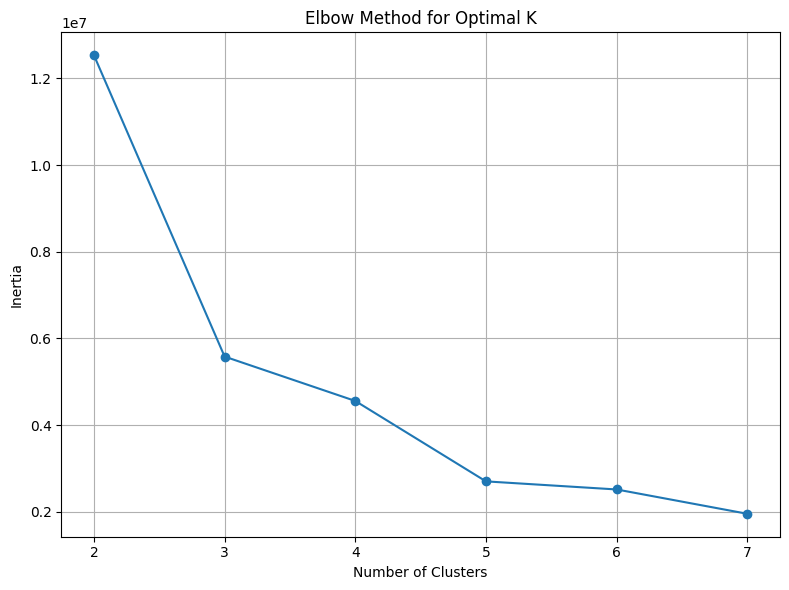

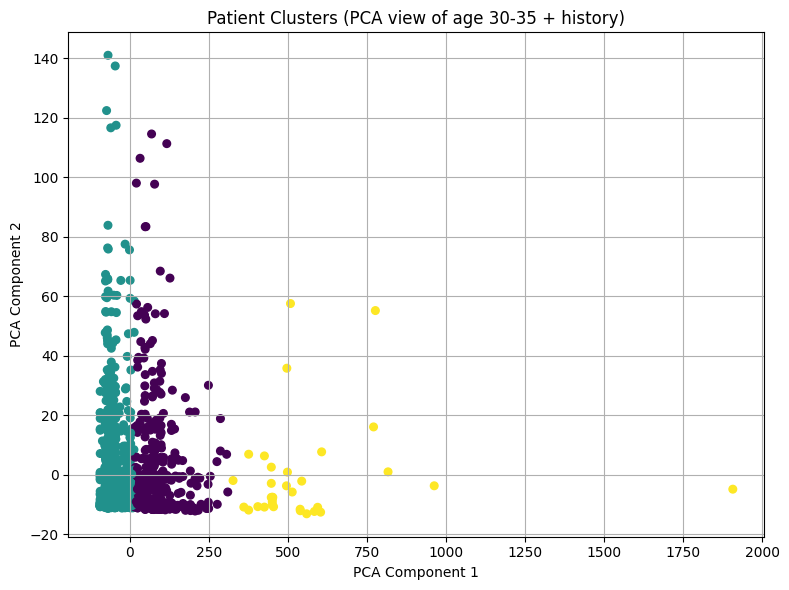

Procedure code occurence distribution for each group distribution


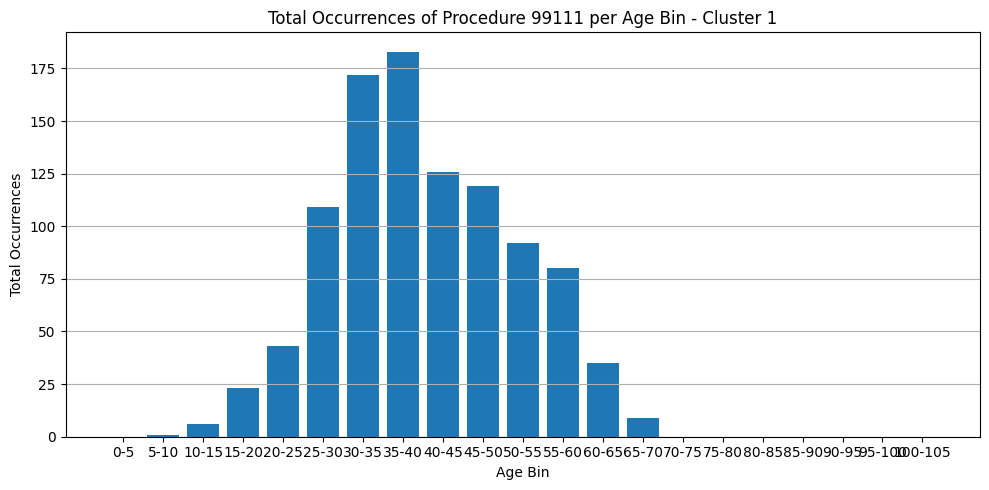

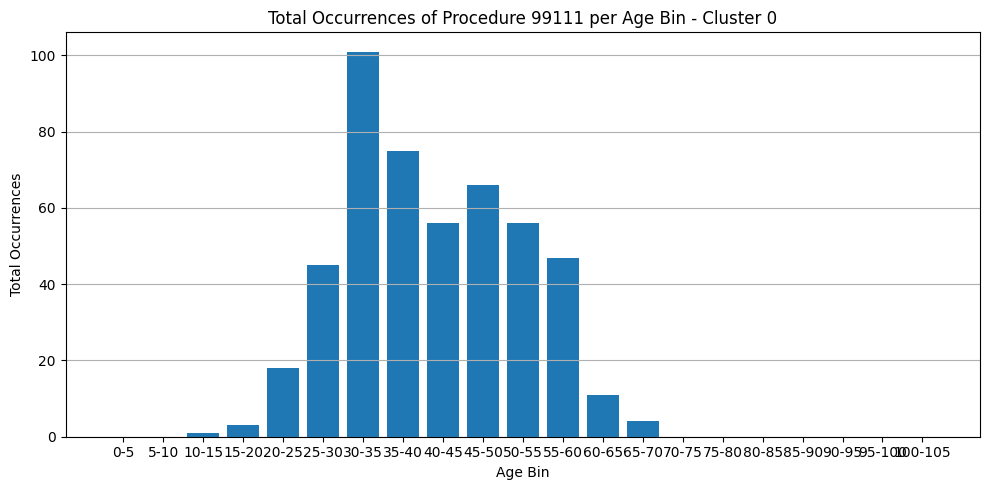

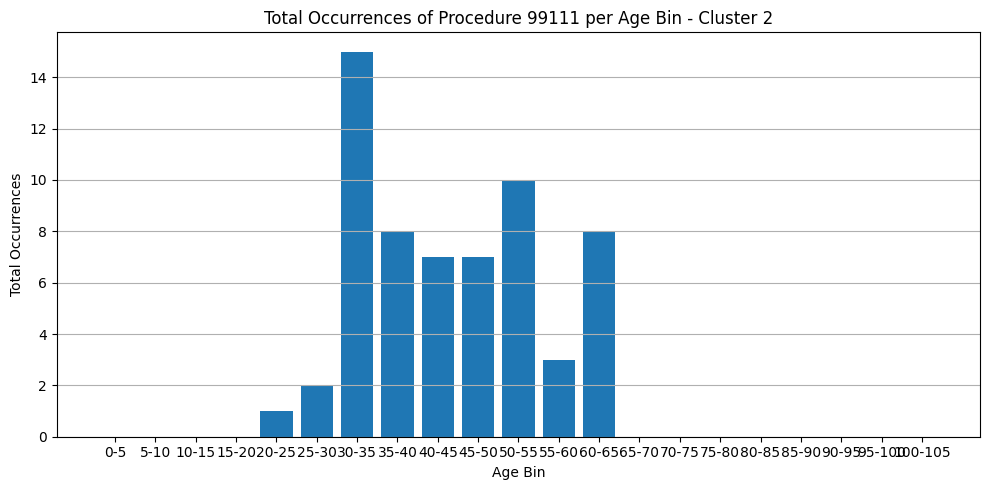

Procedure code mean occurence distribution for each group distribution


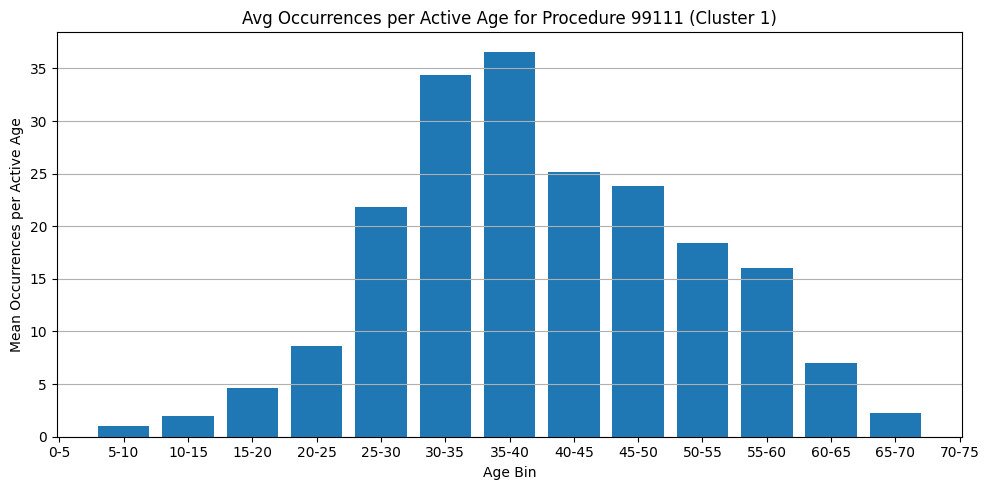

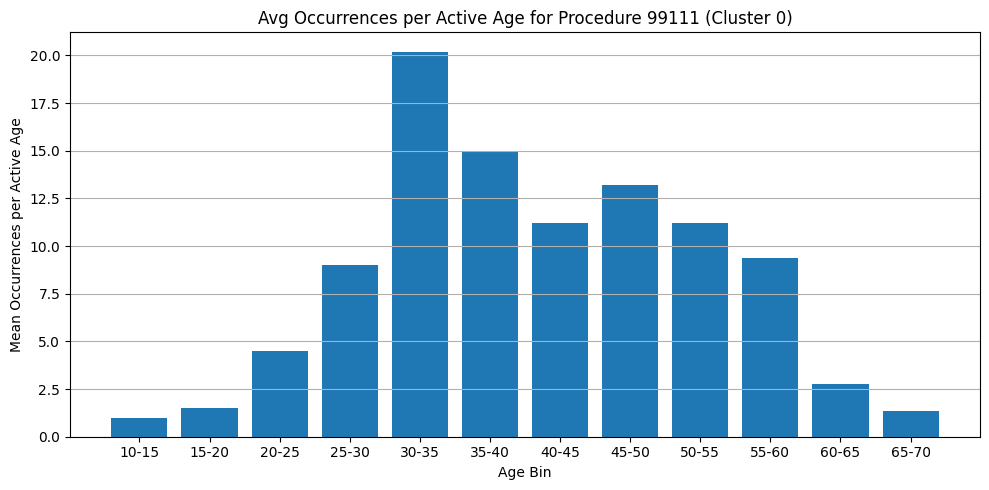

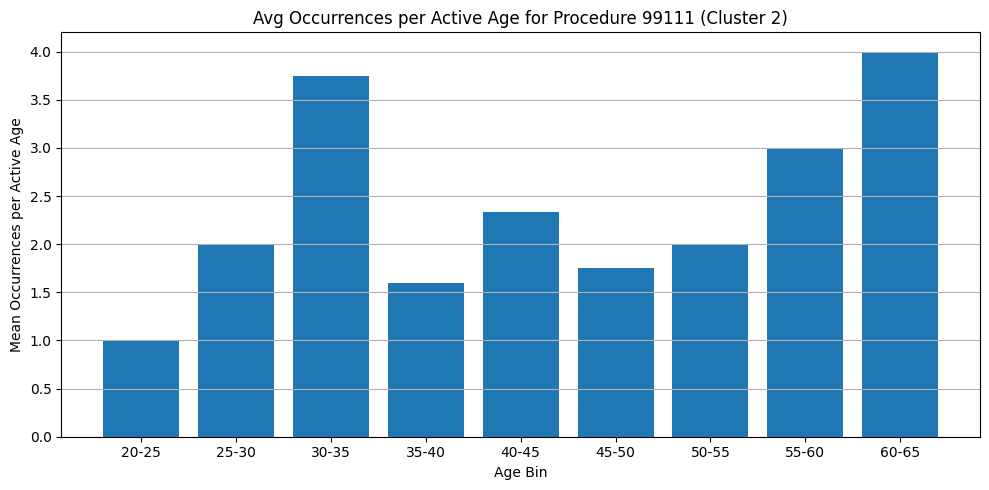

The Top Popular Procedure Codes by Cluster:

Cluster 0:
  procedure_code  count price                     category  \
0          23322    629   300                  Restoration   
1          23321    561   240                  Restoration   
2          99111    483  I.C.  Adjunctive General Services   
3          23323    455   360                  Restoration   
4          23324    280   432                  Restoration   
5          23312    260   275                  Restoration   
6          43413    247  None                         None   
7          27211    237  1073                  Restoration   
8          43412    213  None                         None   
9          23311    208   220                  Restoration   

                                         description  
0  Restorations, Tooth Coloured, Permanent Poster...  
1  Restorations, Tooth Coloured, Permanent Poster...  
2  +L Commercial Laboratory Procedures (A commerc...  
3  Restorations, Tooth Coloured, Permanen

In [8]:
# Key Ouputs:
kmeans_clustering(df_combined, lower_boundary, upper_boundary, scale=False)

print('Procedure code occurence distribution for each group distribution')
plot_procedure_distribution(df_proc_timelines, target_code, average=False)

print('Procedure code mean occurence distribution for each group distribution')
plot_procedure_distribution(df_proc_timelines, target_code, average=True)

table_basic = {}
table_non_basic = {}
for cluster_id in range(optimal_k):
    table_basic[cluster_id] = get_top_procedures_by_cluster(cluster_id, df_proc_timelines, Procedure_code_description_path, True, 10)
    table_non_basic[cluster_id] = get_top_procedures_by_cluster(cluster_id, df_proc_timelines, Procedure_code_description_path, False, 10)

print("The Top Popular Procedure Codes by Cluster:")
for cluster_id, table in table_basic.items():
    print(f"\nCluster {cluster_id}:\n{table}")

print('The Top Non-basic Popular Procedure Codes by Cluster:')
for cluster_id, table in table_non_basic.items():
    print(f"\nCluster {cluster_id}:\n{table}")